# Project - Movielens 영화 SBR

- `Movielens 1M Dataset`을 기반으로 Session Based Recommendation 시스템을 제작한다.

In [18]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

2.2.1
2.10.0


In [19]:
import datetime as dt
from pathlib import Path
import os
import time
from datetime import datetime
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [20]:
data_path = Path('./data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 이전에는 `SessionID`가 들어있었으나, 이번에는 `UserID`가 들어있는 데이터이다.
    - 명확한 1회 세션의 SessionID를 포함하고 있지 않다. (`UserID`가 `SessionID`의 역할을 해야됨)
    - `Rating` 정보가 포함되어 있다. (직전에 봤던 영화가 맘에 들었는지가 비슷한 영화를 더 고르게 하는 것처럼 영향을 줄 수 있음)
    - `Time` 항목에는 UTC time이 포함되어 **1970 1월 1일 부터 경과된 초 단위 시간**이 기재되어 있다.

In [21]:
data["UserId"].nunique(), data["ItemId"].nunique

(6040,
 <bound method IndexOpsMixin.nunique of 31         3186
 22         1270
 27         1721
 37         1022
 24         2340
            ... 
 1000019    2917
 999988     1921
 1000172    1784
 1000167     161
 1000042    1221
 Name: ItemId, Length: 1000209, dtype: int32>)

### Time 컬럼 전처리 및 Session ID 컬럼 생성

- 데이터셋이 Session이 아닌, UserId로 되어 있기 때문에 이를 바탕으로 Session의 역할을 할 수 있도록 조정하는 과정이 필요
    - UserId로만 했을 때, 오류가 발생한다. 이는 UserId 하나로는 **시간을 구분할 수 없기 때문이다.**
    - 또한 Time으로만 했을 때도 동일한데, **User의 구분이 불가능하기 때문이다.**
- 따라서 UserId와 Time을 하나로 묶어서 Session으로 정리해준다.

In [22]:
data['Time'] = pd.to_datetime(data['Time'], unit='s', origin=pd.Timestamp('1970-01-01'))

In [23]:
# UserId와 Time을 기준으로 새로운 데이터프레임 생성
df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
df.reset_index(inplace=True)
df

,index,UserId,Time,ItemId
0,0,1,2000-12-31 22:00:19,1
1,1,1,2000-12-31 22:00:55,3
2,2,1,2000-12-31 22:01:43,1
3,3,1,2000-12-31 22:02:52,1
4,4,1,2000-12-31 22:04:35,1
...,...,...,...,...
471158,471158,6040,2001-08-10 14:39:58,1
471159,471159,6040,2001-08-10 14:40:29,1
471160,471160,6040,2001-08-10 14:41:04,2
471161,471161,6040,2001-08-10 14:41:26,1


In [24]:
data = pd.merge(data, df, on=['UserId', 'Time'])
data.drop(columns='ItemId_y', inplace=True)
data.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,2000-12-31 22:00:19,0
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
4,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000204,6040,2917,4,2001-08-10 14:40:29,471159
1000205,6040,1921,4,2001-08-10 14:41:04,471160
1000206,6040,1784,3,2001-08-10 14:41:04,471160
1000207,6040,161,3,2001-08-10 14:41:26,471161


### User Length

- 각 유저별로 몇 개의 클릭 데이터를 갖는지 확인한다.
    - groupby 함수 적용 후, size()를 통해 row의 개수를 파악한다.
    - count 시 모든 열에 대한 count 누계합이 나오게 된다. (return이 dataframe 형태)

In [25]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [26]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [27]:
user_length.min(), user_length.max()

(20, 2314)

In [28]:
user_length.quantile(0.999)

1343.181000000005

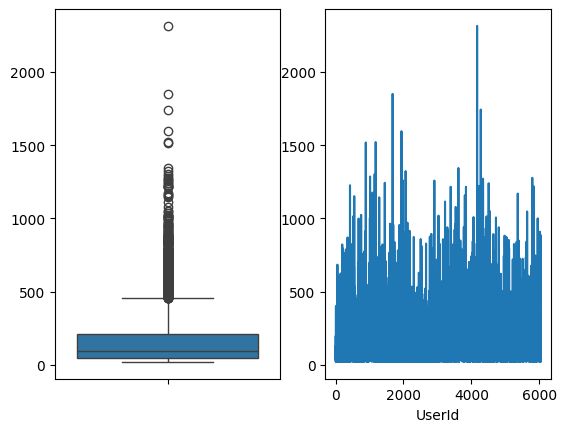

In [29]:
import seaborn as sns


plt.subplot(1, 2, 1)
sns.boxplot(user_length)

plt.subplot(1, 2, 2)
user_length.plot();

- MAX값인 2314개를 갖는 데이터를 찾아본다.
    - 확인해서 무슨 이상이 있는지 파악하기 위함

In [30]:
long_user = user_length[user_length==2314].index[0]
data[data['UserId'] == long_user]

,UserId,ItemId,Rating,Time,SessionId
695642,4169,1268,5,2000-08-03 20:09:52,324780
695643,4169,2617,4,2000-08-03 20:09:52,324780
695644,4169,2628,4,2000-08-03 20:09:52,324780
695645,4169,2653,4,2000-08-03 20:09:52,324780
695646,4169,423,3,2000-08-03 20:09:52,324780
...,...,...,...,...,...
697951,4169,3754,2,2002-06-15 20:52:27,325459
697952,4169,1413,3,2002-06-15 21:03:51,325460
697953,4169,494,4,2002-06-15 21:16:00,325461
697954,4169,1804,2,2002-06-15 21:16:23,325462


- 거의 같거나 매우 짧은 시간 안에 여러번의 클릭을 한 것을 알 수 있다. **(Time = 965333392)**
- 혹은 매우 짧은 시간 동안 많은 클릭을 한 것을 볼 수 있습니다.

In [31]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

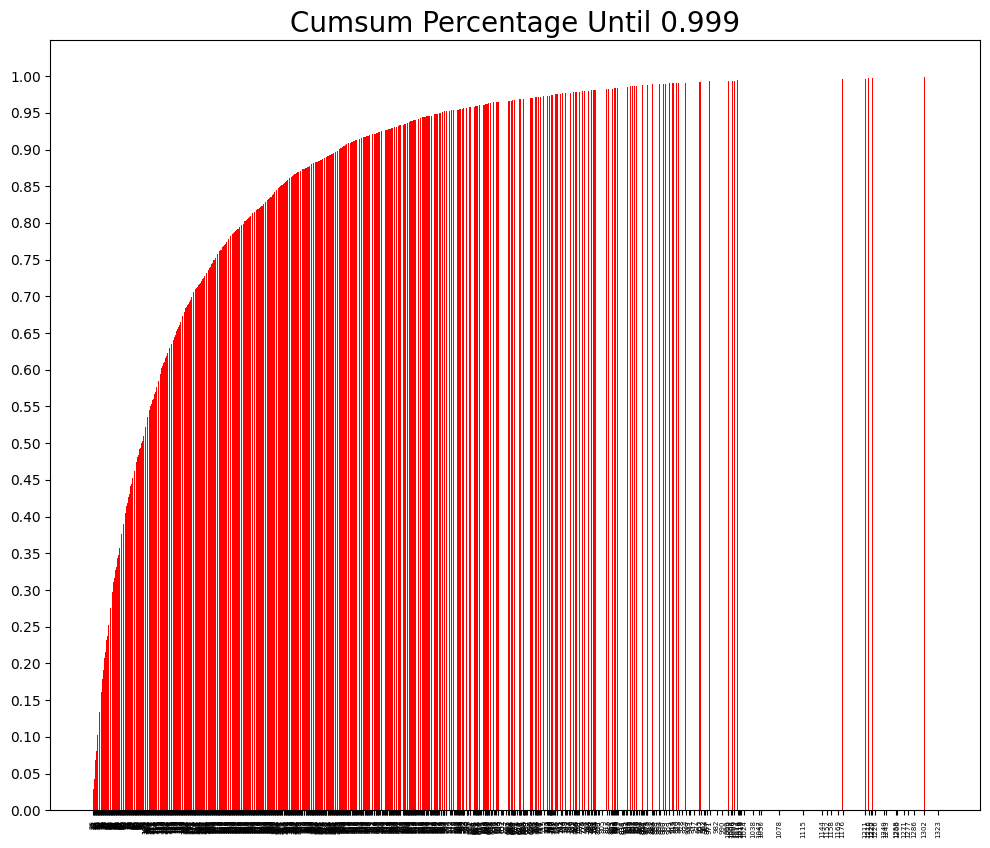

In [32]:
plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index, 
           rotation=90,
           fontsize=5)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time

- 빠르게 변하는 사용자 소비 패턴을 위해 최근 소비 트랜드를 분석한다.
- 가장 최근 데이터 기준으로 30일 내에 구매한 자료를 추출한다.

In [33]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [34]:
# month_ago =  latest - dt.timedelta(50)
# data = data[data["Time"] > month_ago]
# data

In [35]:
data.groupby("ItemId").count()["UserId"].value_counts()

UserId
1       114
2        89
4        45
3        42
5        39
       ... 
593       1
2583      1
997       1
2278      1
437       1
Name: count, Length: 924, dtype: int64

### Data Cleansing

In [36]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [37]:
data = cleanse_recursive(data, shortest=2, least_click=2)
data

,UserId,ItemId,Rating,Time,SessionId
1,1,1270,5,2000-12-31 22:00:55,1
2,1,1721,4,2000-12-31 22:00:55,1
3,1,1022,5,2000-12-31 22:00:55,1
7,1,2804,5,2000-12-31 22:11:59,5
8,1,1207,4,2000-12-31 22:11:59,5
...,...,...,...,...,...
1000189,6040,3362,4,2001-08-10 14:29:56,471145
1000190,6040,3421,3,2001-08-10 14:31:49,471146
1000191,6040,1258,4,2001-08-10 14:31:49,471146
1000205,6040,1921,4,2001-08-10 14:41:04,471160


### Dataset 분리

In [38]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [39]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [40]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [41]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 773830
	 Sessions: 244943
	 Items: 3503
	 First Time : 2000-04-25 23:05:54
	 Last Time : 2003-02-25 19:06:15

* valid Set Stats Info
	 Events: 6
	 Sessions: 3
	 Items: 6
	 First Time : 2003-02-27 17:44:58
	 Last Time : 2003-02-27 17:45:48

* test Set Stats Info
	 Events: 10
	 Sessions: 5
	 Items: 10
	 First Time : 2003-02-27 17:51:30
	 Last Time : 2003-02-28 17:49:08



In [42]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [43]:
save_path = data_path / 'processed_project'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Data Pipeline

In [44]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [45]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,item_idx
1,1,1270,5,2000-12-31 22:00:55,1,0
2,1,1721,4,2000-12-31 22:00:55,1,1
3,1,1022,5,2000-12-31 22:00:55,1,2
7,1,2804,5,2000-12-31 22:11:59,5,3
8,1,1207,4,2000-12-31 22:11:59,5,4
9,1,1193,5,2000-12-31 22:12:40,6,5
10,1,720,3,2000-12-31 22:12:40,6,6
11,1,260,4,2000-12-31 22:12:40,6,7
19,1,1035,5,2000-12-31 22:29:13,14,8
20,1,1962,4,2000-12-31 22:29:13,14,9


In [46]:
tr_dataset.click_offsets

array([     0,      3,      5, ..., 773826, 773828, 773830])

In [47]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 244940, 244941, 244942])

### Session Data Loader

In [48]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [49]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,item_idx
1,1,1270,5,2000-12-31 22:00:55,1,0
2,1,1721,4,2000-12-31 22:00:55,1,1
3,1,1022,5,2000-12-31 22:00:55,1,2
7,1,2804,5,2000-12-31 22:11:59,5,3
8,1,1207,4,2000-12-31 22:11:59,5,4
9,1,1193,5,2000-12-31 22:12:40,6,5
10,1,720,3,2000-12-31 22:12:40,6,6
11,1,260,4,2000-12-31 22:12:40,6,7
19,1,1035,5,2000-12-31 22:29:13,14,8
20,1,1962,4,2000-12-31 22:29:13,14,9


In [50]:
iter_ex = iter(tr_data_loader)

In [51]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 8]
Label Item Idx are :       [1 4 6 9]
Previous Masked Input Idx are []


### Modeling

In [52]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### Model Architecture

In [53]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [54]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [55]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [56]:
model = create_model(args)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(2048, 1, 3503)]         0         
                                                                 
 GRU (GRU)                   [(2048, 50),              533250    
                              (2048, 50)]                        
                                                                 
 dropout (Dropout)           (2048, 50)                0         
                                                                 
 dense (Dense)               (2048, 3503)              178653    
                                                                 
Total params: 711,903
Trainable params: 711,903
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [57]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [58]:
train_model(model, args)

Train:  99%|█████████▉| 256/258 [00:30<00:00,  8.51it/s, accuracy=0.00146, train_loss=7.39] 
Evaluation: 0it [00:00, ?it/s]


IndexError: index 3 is out of bounds for axis 0 with size 3